In [1]:
import numpy  as np
import pandas as pd
import data_tools
import matplotlib.pyplot as plt

from Models.models import *

In [2]:
ts = pd.read_csv('Preprocessed_data/ts.csv')

log_diff_prices = ts.price.values
log_diff_prices = np.array(log_diff_prices, dtype=float)
log_diff_prices = np.diff(np.log(log_diff_prices))
log_diff_prices = np.concatenate((np.array([0]), log_diff_prices))
ts['log_diff_prices'] = log_diff_prices

yearmonth = list(ts['yearmonth'])
x_label   = data_tools.from_index_to_dates(yearmonth)

ts['X'] = np.zeros(ts.shape[0])

for t in ts.index:
    if t == 0:
        continue
        
    curr_price = ts.loc[t  , 'price']
    prev_price = ts.loc[t-1, 'price'] 
    
    ts.loc[t,'X'] = residual(prev_price,curr_price,t)


In [10]:
ts

,yearmonth,price,storage,inflow,outflow,elevation,evaporation,log_diff_prices,X
0,200401,0.090,2423.144516,64.557774,38.687065,174.703871,2.294,0.000000,0.000000
1,200402,0.090,2556.166034,96.107276,46.154448,175.564310,2.945,0.000000,-0.011040
2,200403,0.090,2588.537645,79.366548,52.743226,175.769871,4.587,0.000000,-0.018150
3,200404,0.091,2638.082300,78.393133,37.528267,176.078700,5.578,0.011050,-0.009975
4,200405,0.094,2668.301839,46.613065,58.082258,176.266323,6.569,0.032435,0.013542
...,...,...,...,...,...,...,...,...,...
187,201908,0.142,2352.248000,21.151742,55.178516,174.229129,7.334,0.000000,0.006353
188,201909,0.143,2255.985500,20.976100,29.964867,173.568067,5.805,0.007018,0.020480
189,201910,0.143,2202.691774,27.515710,9.802129,173.194258,3.964,0.000000,0.016337
190,201911,0.142,2333.484000,83.207033,1.412100,174.099333,3.058,-0.007018,0.007189


In [12]:
prediction_inflow = []

current_time = 0

for i in range(190):
    current_time += 1
    
    prev_inflow = ts.inflow.values[current_time - 1]
    pred_inflow = model_inflow(current_time, prev_inflow)
    
    prediction_inflow.append(pred_inflow)
    
prediction_inflow = np.array(prediction_inflow)

In [13]:
np.std(pred_inflow - ts.inflow.values[1:])

66.9631265035845

In [5]:
ts_forecast = ts.copy()

In [6]:
# Forecasting Prices M steps ahead

M = 100

for i in range(1,M+1,1):
    
    current_time = time + i
    
    prev     = ts_forecast.loc[current_time-1,  'price']
    prev_x   = ts_forecast.loc[current_time-1,  'X']
    prev_y_x = ts_forecast.loc[current_time-12, 'X']
    
    log_P      = model_log_prices(current_time,prev, prev_x, prev_y_x)
    curr_price = np.exp(log_P)
    
    ts_forecast.loc[current_time,'price'] = curr_price
    
    X = residual(prev,curr_price,current_time)
    ts_forecast.loc[current_time,'X'] = X

In [7]:
ts_forecast

,yearmonth,price,storage,inflow,outflow,elevation,evaporation,log_diff_prices,X
0,200401.0,0.090000,2423.144516,64.557774,38.687065,174.703871,2.294,0.000000,0.000000e+00
1,200402.0,0.090000,2556.166034,96.107276,46.154448,175.564310,2.945,0.000000,-1.104011e-02
2,200403.0,0.090000,2588.537645,79.366548,52.743226,175.769871,4.587,0.000000,-1.814998e-02
3,200404.0,0.091000,2638.082300,78.393133,37.528267,176.078700,5.578,0.011050,-9.974713e-03
4,200405.0,0.094000,2668.301839,46.613065,58.082258,176.266323,6.569,0.032435,1.354170e-02
...,...,...,...,...,...,...,...,...,...
287,NaN,0.177828,NaN,NaN,NaN,NaN,NaN,NaN,9.367507e-17
288,NaN,0.178113,NaN,NaN,NaN,NaN,NaN,NaN,-4.813858e-17
289,NaN,0.180090,NaN,NaN,NaN,NaN,NaN,NaN,-5.724587e-17
290,NaN,0.183388,NaN,NaN,NaN,NaN,NaN,NaN,-3.816392e-17


In [34]:
# Forecasting Storage water N steps ahead

N = 100

for i in range(1,N+1,1):
    
    current_time = time + i
    
    prev_inflow  = ts_forecast.loc[current_time - 1, 'inflow' ]
    prev_storage = ts_forecast.loc[current_time - 1, 'storage']
    
    current_storage = model_storage(model_inflow,prev_inflow, model_evaporation, current_time, prev_storage, prev_inflow) # this prev inflow is wrong, it should be outflow
    current_inflow  = model_inflow(current_time, prev_inflow)
    
    ts_forecast.loc[current_time,'storage'] = current_storage
    ts_forecast.loc[current_time,'inflow']  = current_inflow

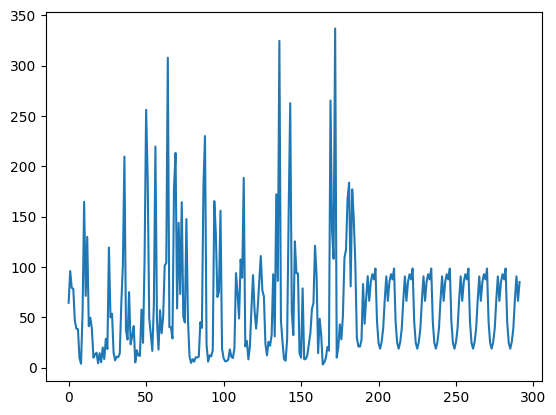

In [40]:
ts_forecast.inflow.plot()
plt.show()

In [8]:
ts_forecast.price.plot()

<AxesSubplot:>

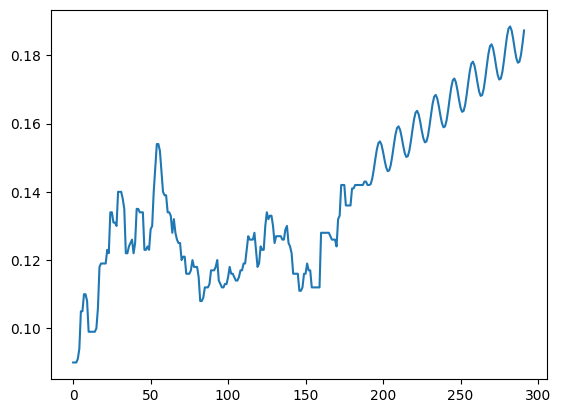

In [9]:
plt.show()

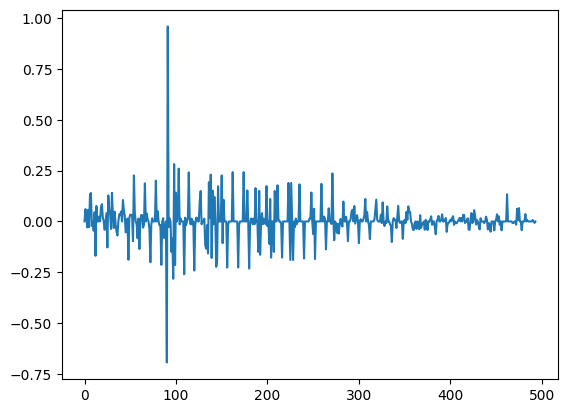

In [13]:
ts_forecast.pr.plot()
plt.show()

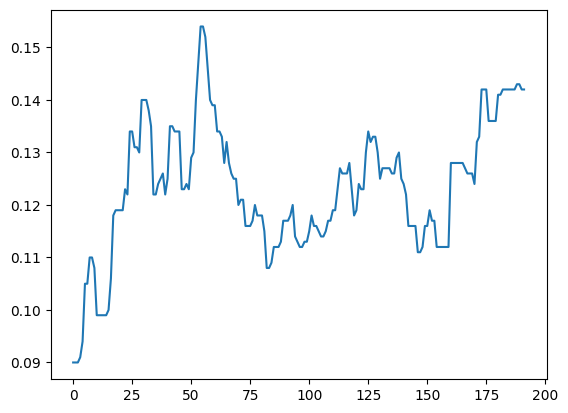

In [14]:
plt.plot(ts.price.values)
plt.show()